<a href="https://colab.research.google.com/github/ziadelsharawy/Test/blob/main/Eye_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.models import load_model
import random
import os
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LeakyReLU, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import  EarlyStopping
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing import image
import pickle
import tensorflow as tf


In [ ]:
Data="/kaggle/input/eye-diseases-classification/dataset"
CATOGRY=["cataract","diabetic_retinopathy","glaucoma","normal"]

In [ ]:
Image_Size=224

df = []

for category in CATOGRY:
    folder = os.path.join(Data, category)
    label = CATOGRY.index(category)
    for imge in os.listdir(folder):
        imge_path = os.path.join(folder, imge)
        imge_arr = cv2.imread(imge_path)
        imge_arr = cv2.resize(imge_arr, (Image_Size, Image_Size))
        image = imge_arr / 255.0
        df.append([image, label])


In [ ]:
len(df)

4217

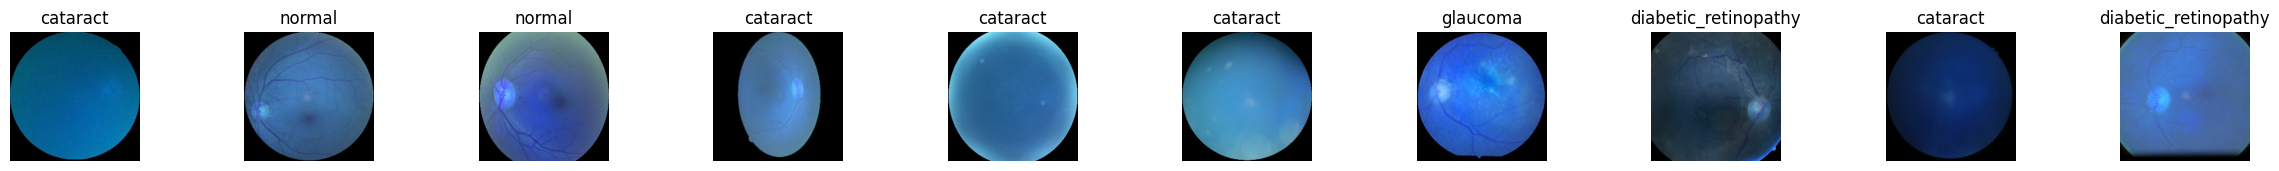

In [ ]:
random.shuffle(df)
plt.figure(figsize=(60, 50))
for i in range(10):
    plt.subplot(25, 20, i+1)
    plt.imshow(df[i][0])
    plt.title(CATOGRY[df[i][1]])
    plt.axis('off')
plt.show()

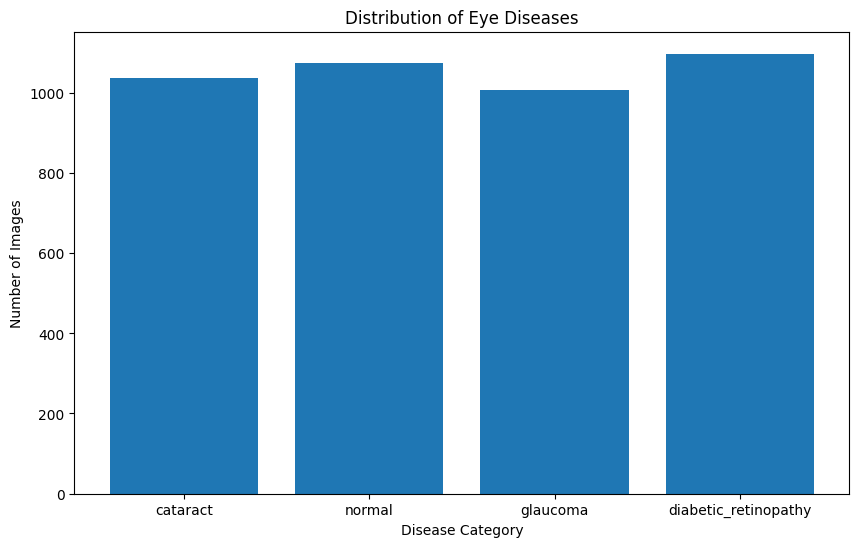

In [ ]:
# Count the occurrences of each category
category_counts = Counter([CATOGRY[label] for _, label in df])

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Disease Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Eye Diseases')
plt.show()

In [ ]:
X=[]
y=[]
for features ,labels in df :
    X.append(features)
    y.append(labels)

In [ ]:
X=np.array(X)
y=np.array(y)
X.shape,y.shape

((4217, 224, 224, 3), (4217,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=48, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.10, random_state=48, shuffle=True)

# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_validate shape:", X_validate.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_validate shape:", y_validate.shape)


X_train shape: (3415, 224, 224, 3)
X_test shape: (422, 224, 224, 3)
X_validate shape: (380, 224, 224, 3)
y_train shape: (3415,)
y_test shape: (422,)
y_validate shape: (380,)


In [ ]:
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = True  # Unfreeze the base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Typically used to aggregate feature maps
    x = Dense(2048, kernel_regularizer=l2(0.3))(x)  # Added L2 regularization
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.9)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model1 = Model(inputs=base_model.input, outputs=x)

    optimizer = Adam(learning_rate=1e-5)

    model1.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model1

input_shape = (224, 224, 3)  # Example input shape, adjust as needed
num_classes = 4  # Adjust based on your number of classes

model1 = build_resnet_model(input_shape, num_classes)
model1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 27,792,260 (106.02 MB)

 Trainable params: 27,739,140 (105.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history1 = model1.fit(
    X_train, y_train,
    epochs=14,
    validation_data=(X_validate, y_validate),
    batch_size=32,
    callbacks=[early_stopping]

)


Epoch 1/14


I0000 00:00:1723986308.435490    4322 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.2766 - loss: 605.4174

W0000 00:00:1723986361.123054    4324 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 137s 592ms/step - accuracy: 0.2771 - loss: 605.3152 - val_accuracy: 0.2368 - val_loss: 572.2253
Epoch 2/14
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.4917 - loss: 561.5545 - val_accuracy: 0.2368 - val_loss: 530.8367
Epoch 3/14
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.6495 - loss: 520.2919 - val_accuracy: 0.2447 - val_loss: 491.6222
Epoch 4/14
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.7167 - loss: 481.3351 - val_accuracy: 0.2526 - val_loss: 454.4411
Epoch 5/14
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.7957 - loss: 444.5170 - val_accuracy: 0.2500 - val_loss: 419.3515
Epoch 6/14
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8392 - loss: 409.8807 - val_accuracy: 0.2921 - val_loss: 386.3869
Epoch 7/14
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8681 - loss: 377.3832 - val_accuracy: 0.3842 - val_loss: 355.4531
Epoch 8/14
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy

In [ ]:
loss, accuracy = model1.evaluate(X_test, y_test)

print("Loss of the model is - ", loss)
print("Accuracy of the model is - ", accuracy * 100, "%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.9513 - loss: 188.4841
Loss of the model is -  188.5214385986328
Accuracy of the model is -  94.3127989768982 %


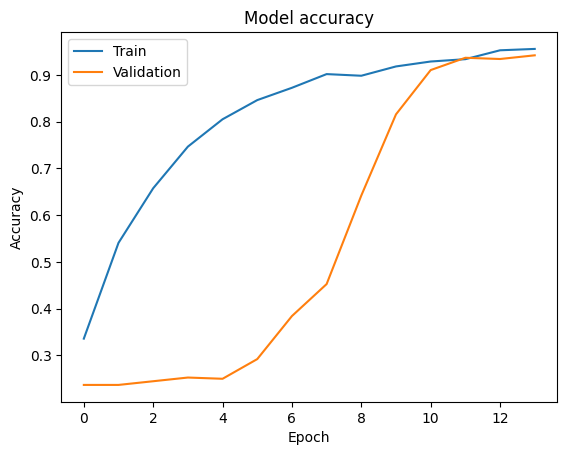

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

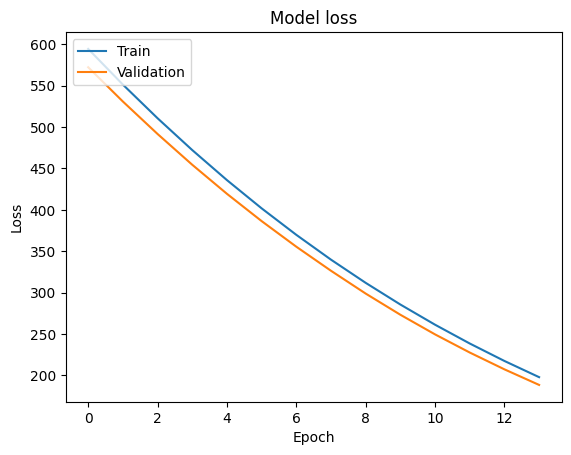

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_prob = model1.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Accuracy: 0.943127962085308
Precision: 0.9433520910461533
Recall: 0.943127962085308
F1 Score: 0.9430173542094332
Confusion Matrix:
[[108   0   4   0]
 [  0 111   0   0]
 [  3   0  87  11]
 [  0   0   6  92]]


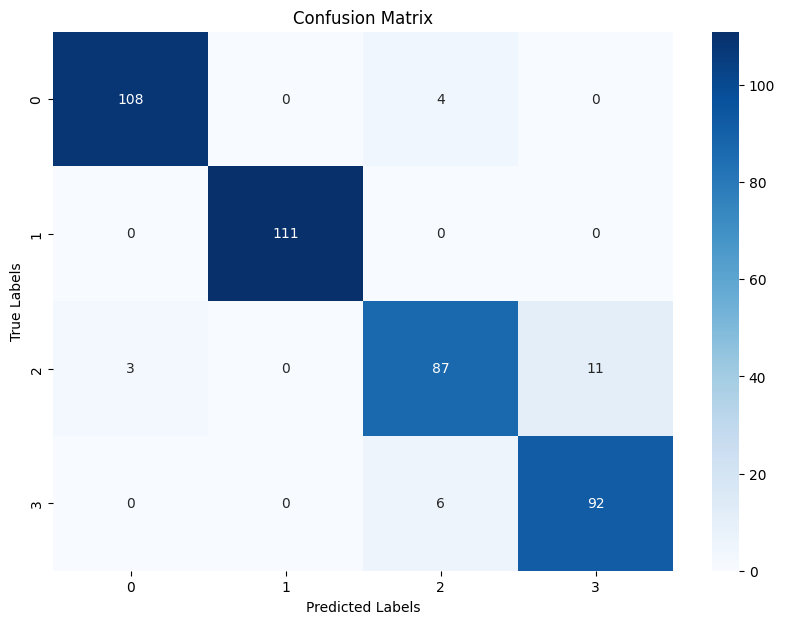

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def list_image_files(directory_path, extensions=('.jpg', '.jpeg', '.png')):
    all_files = os.listdir(directory_path)
    image_files = [os.path.join(directory_path, f) for f in all_files if f.lower().endswith(extensions)]
    return image_files

In [ ]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
def display_image_with_prediction(img_path, prediction, class_labels, threshold=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert prediction to class label
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    predicted_prob = np.max(prediction)  # Get the highest probability

    if predicted_prob > threshold:
        predicted_class = class_labels[predicted_class_idx]
    else:
        predicted_class = "Other diseases"

    plt.imshow(img)
    plt.title(f'Prediction: {predicted_class}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


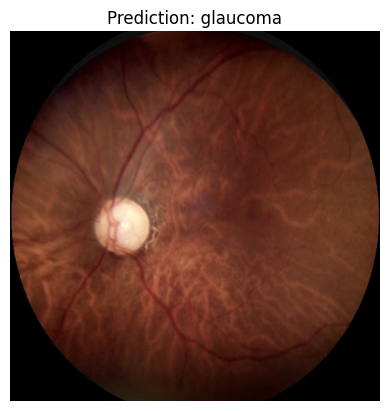

In [ ]:
class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Path to the image
img_path = "/kaggle/input/eye-diseases-classification/dataset/glaucoma/1212_left.jpg"

# Preprocess the image
preprocessed_image = preprocess_image(img_path)

# Predict the class
predictions = model1.predict(preprocessed_image)

# Display the image with prediction
display_image_with_prediction(img_path, predictions, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


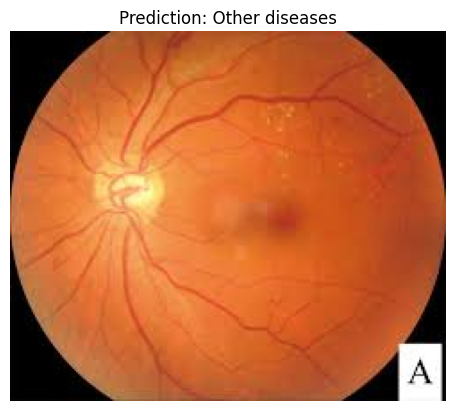

In [ ]:
directory_path = '/kaggle/input/diabetic-retinopathy'  # Update with your directory path

# List all image files in the directory
image_files = list_image_files(directory_path)

# Check if there are any images
if image_files:
    # Use the first image file for demonstration
    img_path = image_files[0]

    # Preprocess the image
    preprocessed_image = preprocess_image(img_path)

    # Predict the class
    predictions = model1.predict(preprocessed_image)

    # Display the image with prediction
    class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]
    display_image_with_prediction(img_path, predictions, class_labels, threshold=0.5)
else:
    print("No image files found in the directory.")

In [ ]:
model1.save('model1.h5')

# 2. Save class labels with pickle
class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]
with open('class_labels.pkl', 'wb') as file:
    pickle.dump(class_labels, file)

# 3. Load the model and class labels
# Load the Keras model
model1 = load_model('model1.h5')

# Load class labels
with open('class_labels.pkl', 'rb') as file:
    class_labels = pickle.load(file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


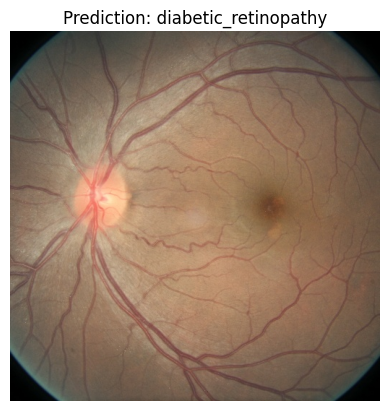

In [ ]:
# Example usage of loaded model and class labels
img_path = '/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10009_right.jpeg'  # Update with an actual file path

# Preprocess the image
preprocessed_image = preprocess_image(img_path)

# Predict the class
predictions = model1.predict(preprocessed_image)

# Display the image with prediction
display_image_with_prediction(img_path, predictions, class_labels, threshold=0.5)